# Analyze GP articles

### Goal

The goal is to explore some basic text processing techniques.
1. Get top words for different years
2. Build classifier to detect article type by it`s content

### Fire up Pandas

Trick to insatll a package in docker container

In [25]:
import pip    
def install(package):
   pip.main(['install', package])

install('nltk')
install('stop_words')

In [79]:
import csv
import operator
import os
import pandas
import re
import sklearn
import string
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from stop_words import get_stop_words

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [27]:
import nltk
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [28]:
data_dir = 'data/gp'
separator = '|'
column_names = ['link', 'date', 'title', 'category', 'body']

### Read some article data

In [29]:
file_name = os.path.join(data_dir, 'gpdump0.csv')
products = pandas.read_csv(file_name, delimiter=separator)

In [30]:
len(products)

411

Look at the data

In [31]:
products.head()

,http://www.gp.se/1.226,2016-02-24,Applåder till tjänstemän i möte om flyktingbostäder,nyheter,"Kommunens tjänstemän fick till och med applåder när mötet avslutades.Att råskället inte var det som dominerade i Glöstorpskyrkan berodde förmodligen på en märkbar närvaro av medlemmar i facebookgruppen Tillsammans i Tuve, som sedan starten för två veckor sedan fått över 800 medlemmar. Initiativtagare till den är Sükran Dogan, som bott i Tuve i 31 av sina 34 år.– Jag är för flyktingbostäder men tycker att modulerna skulle vara mer utspridda än i förslaget. Detta tycker jag att man måste kunna ha en saklig diskussion om.Sükran Dogan är – Gamla skolkamrater har slutat hälsa, de bara sneglar på mig. Det är läskigt.För de kommunala topptjänstemännen var gårdagskvällens möte det sjätte om flyktingbostäder. Glöstorpkyrkans 350 platser i kyrk- och församlingssal blev snabbt fulla, och de 150 som inte kom in fick besked att ett ytterligare möte skulle avlösa det fullsatta.Även om flera välkomnande inlägg fick applåder, blev det också bifall till en rad starkt kritiska. De handlade om personlig säkerhet, och geoteknisk säkerhet.Flera personer undrade hur kommunen kunde föreslå en plats så nära Tuverasets.Fastighetsdirektör Magnus Sigfusson svarade att inga markundersökningar ännu gjorts, men att sådana ska göras om platsen blir aktuell. På en fråga om alternativa lokaliseringar nämnde Sigfusson att det gamla rasområdet varit en av de som kommunen tittat på men avstått från att gå vidare med.Flera mötesdeltagare sade sig bo ”alldeles i närheten” av de planerade tillfälliga bostäderna, och undrade hur kommunen skall ”trygga säkerheten”.Michael Ivarson, chef för sociala resursförvaltningen, sa sig förstå oron, förklarade att alla ensamkommande har kontaktpersoner bland personalen och hänvisade till vad polisledningen sagt om larm från boenden:– Av alla händelser som polisen åker på är en procent kopplade till boende. Och av dem handlar det i nio fall av tio om konflikter mellan dem som bor där. En stor majoritet av ungdomarna är väldigt motiverade att komma in i samhället, sa Ivarson.En ung kvinna – Hittar vi många platser att bygga på kan vi göra så. Det lämpligaste är 100 till 150 boende per plats men då kanske vi behöver 30 platser i Göteborg i stället för de tolv som nu är på förslag, sa Magnus Sigfusson."
0,http://www.gp.se/1.441,2016-02-25,Ali Khan släpper bok: Lite provocerande,sport,Att Mohammed Ali Khan skrivit en bok kommer in...
1,http://www.gp.se/1.676,2016-02-14,Brittisk popband dog i broolyckan,nyheter,Viola Beach är från staden Warrington och det ...
2,http://www.gp.se/1.879,2016-02-15,Svenska bönder är inga miljöbovar,nyheter,"ReplikMiljövänlig mat, 9/2Jonas Paulsson hävda..."
3,http://www.gp.se/1.1096,2016-02-16,I kväll bjuder Frölunda på en försmak av guld,sport,"ScandinaviumFrölundasGott så, tror jag – och b..."
4,http://www.gp.se/1.1316,2016-02-19,Onsaladådet: 39-åringen erkänner brott,nyheter,Enligt den tidigare planeringen skulle ett bes...


### 1. Get top words for different years

All articles are scattered across files in dump folder. The idea is to concatenate all of them into one big yearly blob, clean it and detect top words.

#### 1.1 Assemble everything together

In [32]:
articles = pandas.DataFrame()

for filename in os.listdir(data_dir):
    if filename.endswith("2.csv"): 
        #print(filename)
        articles = articles.append(pandas.read_csv(
            os.path.join(data_dir, filename), 
            delimiter=separator,
            error_bad_lines=False,
            quoting=csv.QUOTE_ALL,
            #quoting=csv.QUOTE_NONE,
            names=column_names,
            header=None), ignore_index = True)
        continue
    else:
        continue

TODO: Some files contain incorrect data. Need to fix it later

In [33]:
articles.head(10)

,link,date,title,category,body
0,http://www.gp.se/1.289,2016-02-24,VM-hjälten twittrade om presidenten – riskerar...,sport,Åklagare har åtalat Sükür för att på Twitter h...
1,http://www.gp.se/1.625,2016-02-13,"Skrev Anna säg ja!"" i snön – så gick det sedan """,nyheter,Han har varit ihop med sin tjej Anna Bergman s...
2,http://www.gp.se/1.877,2016-02-15,Knarkhandel i Sahlgrenskas entré - tvingas sät...,nyheter,- Det var en helt ohållbar situation som vi in...
3,http://www.gp.se/1.1094,2016-02-16,Hit reser göteborgarna på sportlovet,nyheter,"Gran Canaria, London och Miami. Där har ni göt..."
4,http://www.gp.se/1.1321,2016-02-19,Yoko Ono,noje,Det är omöjligt att skilja på Yoko Onos konst ...
5,http://www.gp.se/1.1566,2016-02-21,"Erik 19, hamnade mitt i Fiji-cyklonen - strand...",nyheter,Nu berättar han om de turbulenta dagarna.- Vi ...
6,http://www.gp.se/1.1835,2016-02-23,Ingemark Stenmarks ilska: Jag hatade det där,sport,För första gången körs parallellslalom som en ...
7,http://www.gp.se/1.2016,2016-02-27,Ku Klux Klan stöder Donald Trump,nyheter,Donald Trump har tidigare gjort uttalanden om ...
8,http://www.gp.se/1.2237,2016-02-29,Kraftig explosion på Hisingen - lägenhet total...,nyheter,En kraftig explosion inträffade på måndagsfö...
9,http://www.gp.se/1.2532,2016-03-01,Larholm aktuell för Sävehof,sport,Sävehof rustar inför flytten till nybyggda Par...


#### Analyze number of articles per day

/env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


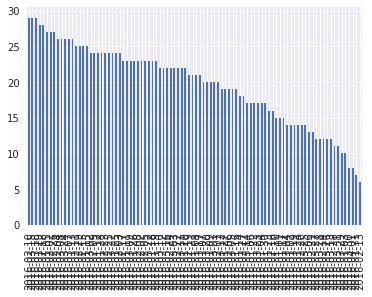

In [34]:
a2016['date'].value_counts().plot(kind='bar')

In [35]:
a2015['date'].value_counts()

2015-04-24    28
2015-01-22    27
2015-03-24    27
2015-03-13    27
2015-02-13    27
2015-02-06    27
2015-03-05    27
2015-01-29    26
2015-04-14    26
2015-03-25    26
2015-02-20    26
2015-03-06    26
2015-02-26    26
2015-03-27    26
2015-01-14    26
2015-03-17    26
2015-04-30    25
2015-04-20    25
2015-04-29    25
2015-03-31    25
2015-03-11    25
2015-02-17    25
2015-04-23    25
2015-03-20    25
2015-02-23    25
2015-04-15    24
2015-04-08    24
2015-01-19    24
2015-01-16    24
2015-02-19    24
              ..
2015-01-02    14
2015-04-25    14
2015-02-21    14
2015-03-01    14
2015-03-28    14
2015-01-01    14
2015-04-06    14
2015-01-24    14
2015-01-06    13
2015-01-25    13
2015-04-18    13
2015-01-03    13
2015-01-31    13
2015-03-22    13
2015-02-07    12
2015-01-18    12
2015-04-05    12
2015-01-11    11
2015-01-04    11
2015-05-01    11
2015-02-01    11
2015-03-08     9
2015-05-02     3
2015-05-11     1
2015-05-10     1
2015-05-15     1
2015-12-18     1
2015-05-04    

#### 1.2 Now let`s create datasets for years 2014, 2015, 2016, 2017

In [36]:
a2014 = pandas.DataFrame(columns=column_names)
a2015 = pandas.DataFrame(columns=column_names)
a2016 = pandas.DataFrame(columns=column_names)
a2017 = pandas.DataFrame(columns=column_names)

In [37]:
for index ,row in articles.iterrows():
    if row['date'].startswith('2014'):
        a2014 = a2014.append(row)
    elif row['date'].startswith('2015'):
        a2015 = a2015.append(row)
    elif row['date'].startswith('2016'):
        a2016 = a2016.append(row)
    elif row['date'].startswith('2017'):
        a2017 = a2017.append(row)

    

In [38]:
a2014.head()

,link,date,title,category,body


In [39]:
a2015.head()

,link,date,title,category,body
153,http://www.gp.se/1.42327,2015-01-09,Steen målskytt i målfest,sport,De övriga i kedjan är David Backis och T J Osh...
154,http://www.gp.se/1.42498,2015-01-09,Thunebro ersättare i landskamp,sport,Rosengård-försvararen Lina Nilsson är sjuk och...
155,http://www.gp.se/1.42664,2015-01-10,Förre CIA-chefen riskerar åtal,nyheter,Det blir justitieminister Eric Holder som ska ...
156,http://www.gp.se/1.42830,2015-01-10,Två svårt skadade i krock i Umeå,nyheter,Fem personer skadades i en olycka mellan två b...
157,http://www.gp.se/1.43215,2015-01-11,Brandattentat mot tysk dagstidning,nyheter,"Den tyska dagstidningen Hamburger Morgenpost, ..."


In [40]:
a2016.head()

,link,date,title,category,body
0,http://www.gp.se/1.289,2016-02-24,VM-hjälten twittrade om presidenten – riskerar...,sport,Åklagare har åtalat Sükür för att på Twitter h...
1,http://www.gp.se/1.625,2016-02-13,"Skrev Anna säg ja!"" i snön – så gick det sedan """,nyheter,Han har varit ihop med sin tjej Anna Bergman s...
2,http://www.gp.se/1.877,2016-02-15,Knarkhandel i Sahlgrenskas entré - tvingas sät...,nyheter,- Det var en helt ohållbar situation som vi in...
3,http://www.gp.se/1.1094,2016-02-16,Hit reser göteborgarna på sportlovet,nyheter,"Gran Canaria, London och Miami. Där har ni göt..."
4,http://www.gp.se/1.1321,2016-02-19,Yoko Ono,noje,Det är omöjligt att skilja på Yoko Onos konst ...


In [41]:
a2017.head()

,link,date,title,category,body


#### 1.3 Get the top words for each yearly dataset

In [42]:
type(a2015["body"])

pandas.core.series.Series

In [43]:
# clean removes numbers and punctuation from a given article. Only swedish alphabet left.
def clean(x):
    return re.sub("[^a-zåäöA-ZÅÄÖ]", " ", str(x)) 

a2014["body_clean"] = a2014["body"].apply(clean)
a2015["body_clean"] = a2015["body"].apply(clean)
a2016["body_clean"] = a2016["body"].apply(clean)
a2017["body_clean"] = a2017["body"].apply(clean)

In [62]:
# Add stemmer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("swedish")

# Add stopwords
from nltk.corpus import stopwords
sw = stopwords.words("swedish")
new_words = ['int','säg', 'ska','komm', 'und', 'eft', 'tid', 'också', 'enl', 'in', 'år', 'två', 'had', 'ta', 'året'
             'dag', 'vill', 'all', 'även', 'först', 'ell', 'andr', 'fler', 'gör', 'finn', 'skull', 'sen', 'fick', 'bar',
            'er','får', 'kron', 'sver', 'spel','sitt','bland', 'stor', 'del', 'person', 'procent','ann', 'mång','få', 'ing', 'tre', 's']

hdl = open(os.path.join(data_dir, 'sv_stop.txt'), 'r').read().split('\n')
sw.extend(new_words)
sw.extend(hdl)


In [63]:
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

In [64]:
def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

In [65]:
# year 2015
vect2015 = CountVectorizer(tokenizer=tokenize, lowercase=True, stop_words=sw)
features2015 = vect2015.fit_transform(a2015['body_clean'].values.astype('U'))

# year 2016 
vect2016 = CountVectorizer(tokenizer=tokenize, lowercase=True, stop_words=sw)
features2016 = vect2016.fit_transform(a2016['body_clean'].values.astype('U'))

In [66]:
# define function to glue words from vocab and counts
def zip_vocab(voc, counts):
    return dict(zip(voc, counts))

In [67]:
vocab_2015 = vect2015.get_feature_names()
counts_2015 = features2015.sum(axis=0).A1

vocab_2016 = vect2016.get_feature_names()
counts_2016 = features2016.sum(axis=0).A1

In [68]:
dict_2015 = zip_vocab(vocab_2015, counts_2015)
dict_2016 = zip_vocab(vocab_2016, counts_2016)

##### Print top 10 words

In [69]:
# year 2017
#vect2017 = CountVectorizer(tokenizer=tokenize, lowercase=True, stop_words=sw)
#features2017 = vect2017.fit_transform(a2017['body_clean'].values.astype('U'))

In [72]:
# top 10 words for 2015
sorted(dict_2015.items(), key=operator.itemgetter(1), reverse=True)[:10]

[('göteborg', 706),
 ('svensk', 674),
 ('polis', 617),
 ('skriv', 510),
 ('match', 461),
 ('nya', 439),
 ('hel', 438),
 ('båd', 433),
 ('året', 417),
 ('lit', 391)]

In [71]:
# top 10 words for 2016
sorted(dict_2016.items(), key=operator.itemgetter(1), reverse=True)[:10]

[('svensk', 587),
 ('polis', 549),
 ('skriv', 430),
 ('göteborg', 370),
 ('match', 337),
 ('lit', 332),
 ('vis', 307),
 ('båd', 306),
 ('hel', 293),
 ('gång', 290)]

#### Let's count number of occurences of the word

In [60]:
w = 'polis'
w_stemmed = stemmer.stem(w)
print("Searching: ", w)
print("2015: ", dict_2015[w_stemmed])
print("2016: ", dict_2016[w_stemmed])

Searching:  polis
2015:  617
2016:  549


### 2. Build articles classifier

In [74]:
articles.describe()

,link,date,title,category,body
count,4219,4219,4219,4207,4214
unique,4219,221,4206,5,4203
top,http://www.gp.se/1.66445,2016-03-18,Uppåt på Wall Street,nyheter,Mer information kommer inom kort.
freq,1,29,3,2478,10


In [102]:
from sklearn import preprocessing

# cleanup body
articles["body_clean"] = articles["body"].apply(clean)

# Define X and y
X = articles['body_clean']
y = articles['category']

In [103]:
# split into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(3375,)
(844,)


In [104]:
# instantiate the vectorizer
vect = CountVectorizer(tokenizer=tokenize, lowercase=True, stop_words=sw)

In [105]:
# learn training data vocabulary, then create document-term matrix
vect.fit(X_train.values.astype('U'))
X_train_dtm = vect.transform(X_train.values.astype('U'))
X_train_dtm

<3375x39649 sparse matrix of type '<class 'numpy.int64'>'
	with 223027 stored elements in Compressed Sparse Row format>

In [106]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test.values.astype('U'))
X_test_dtm

<844x39649 sparse matrix of type '<class 'numpy.int64'>'
	with 50820 stored elements in Compressed Sparse Row format>

In [123]:
# use logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train_dtm, y_train.values.astype('U'))
logreg.classes_

array(['ledare', 'livsstil', 'nan', 'noje', 'nyheter', 'sport'],
      dtype='<U8')

In [108]:
# class predictions and predicted probabilities
y_pred_class = logreg.predict(X_test_dtm)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]

In [115]:
print(y_pred_class)
# print(y_pred_prob)

['noje' 'nyheter' 'nyheter' 'nyheter' 'nyheter' 'sport' 'nyheter' 'nyheter'
 'nyheter' 'nyheter' 'nyheter' 'nyheter' 'nyheter' 'nyheter' 'nyheter'
 'nyheter' 'nyheter' 'nyheter' 'nyheter' 'sport' 'sport' 'nyheter' 'noje'
 'sport' 'nyheter' 'ledare' 'nyheter' 'nyheter' 'sport' 'nyheter' 'nyheter'
 'nyheter' 'nyheter' 'nyheter' 'noje' 'nyheter' 'nyheter' 'noje' 'nyheter'
 'nyheter' 'sport' 'sport' 'nyheter' 'sport' 'noje' 'nyheter' 'nyheter'
 'nyheter' 'sport' 'noje' 'sport' 'nyheter' 'noje' 'nyheter' 'sport'
 'nyheter' 'nyheter' 'noje' 'sport' 'nyheter' 'nyheter' 'noje' 'nyheter'
 'sport' 'nyheter' 'nyheter' 'nyheter' 'nyheter' 'nyheter' 'noje' 'sport'
 'sport' 'livsstil' 'sport' 'noje' 'nyheter' 'sport' 'nyheter' 'nyheter'
 'nyheter' 'nyheter' 'nyheter' 'nyheter' 'noje' 'nyheter' 'nyheter'
 'nyheter' 'nyheter' 'nyheter' 'noje' 'noje' 'nyheter' 'nyheter' 'nyheter'
 'nyheter' 'nyheter' 'nyheter' 'nyheter' 'nyheter' 'nyheter' 'nyheter'
 'noje' 'nyheter' 'sport' 'nyheter' 'nyheter' 'noje' 

# Evaluate the model

By looking at its accuracy:

In [109]:
# calculate accuracy and AUC
from sklearn import metrics
print(metrics.accuracy_score(y_test.values.astype('U'), y_pred_class))
# print(metrics.roc_auc_score(y_test.values.astype('U'), y_pred_prob))

0.920616113744


In [110]:
print(metrics.confusion_matrix(y_test.values.astype('U'), y_pred_class))
# there is a strange new class. fix it later

[[  1   0   0   0  11   0]
 [  0  11   0   0   8   0]
 [  0   0   0   2   3   0]
 [  0   0   0 104  19   3]
 [  0   0   0   9 484   2]
 [  0   0   0   1   9 177]]


In [118]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  1   0   0   0  11   0]
 [  0  11   0   0   8   0]
 [  0   0   0   2   3   0]
 [  0   0   0 104  19   3]
 [  0   0   0   9 484   2]
 [  0   0   0   1   9 177]]


NameError: name 'itertools' is not defined

/env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


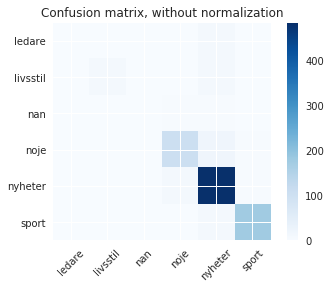

In [124]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test.values.astype('U'), y_pred_class)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['ledare', 'livsstil', 'nan', 'noje', 'nyheter', 'sport'],
                      title='Confusion matrix, without normalization')

plt.show()

### Applying the learned model to predict an article category

In [132]:
yoko = articles[articles['link'] == 'http://www.gp.se/1.1321']

In [133]:
print(yoko)

                      link        date      title category  \
4  http://www.gp.se/1.1321  2016-02-19  Yoko Ono      noje   

                                                body  \
4  Det är omöjligt att skilja på Yoko Onos konst ...   

                                          body_clean  
4  Det är omöjligt att skilja på Yoko Onos konst ...  


In [135]:
# Vectorize Yoko article
yoko_vect_dtm = vect.transform(yoko['body'])
yoko_vect_dtm

<1x39649 sparse matrix of type '<class 'numpy.int64'>'
	with 105 stored elements in Compressed Sparse Row format>

In [136]:
logreg.predict(yoko_vect_dtm)

array(['noje'],
      dtype='<U8')

Yeah! It is news. But the most of articles are news.
So let`s test sport. 
http://www.gp.se/1.289

In [142]:
sport_article = articles[articles['link'] == 'http://www.gp.se/1.289']

In [144]:
# Vectorize sport article
sport_vect_dtm = vect.transform(sport_article['body'])
sport_vect_dtm

<1x39649 sparse matrix of type '<class 'numpy.int64'>'
	with 42 stored elements in Compressed Sparse Row format>

In [145]:
print(sport_article)

                     link        date  \
0  http://www.gp.se/1.289  2016-02-24   

                                               title category  \
0  VM-hjälten twittrade om presidenten – riskerar...    sport   

                                                body  \
0  Åklagare har åtalat Sükür för att på Twitter h...   

                                          body_clean  
0  Åklagare har åtalat S k r för att på Twitter h...  


In [146]:
logreg.predict(sport_vect_dtm)

array(['sport'],
      dtype='<U8')

### It is sport. Yeah!

Now let`s predict unknown to model article category.

In [147]:
art_unknown = pandas.DataFrame(columns=column_names)

In [158]:
art_unknown

,link,date,title,category,body


In [159]:
art_unknown.loc[-1] = ['http://www.gp.se/1.4580602', '2017-08-31', 'Dill förhöjer smakupplevelsen', 'livsstil', 'Dill är en av de finaste örter vi har. Vi borde hylla den oftare. Dillsmak piggar upp, förhöjer och gör livet lite, lite härligare.Finge jag välja en enda smak som står för landet där jag har fötts och vuxit upp i så måste det helt enkelt bli dill. Ingen annan smak kan mäta sig med den fosterlandskärlek jag kan känna när dillen tillåts dominera och ta plats i en rätt. Dill är förvisso ett vanligt inslag såväl i Mellanöstern som i det grekiska köket, men man har blott sin egen nostalgi att utgå ifrån. Det är något med det milda och aromatiskt friska, samtidigt som det ger en vital extrakick utan att någonsin gå för långt. Jag tror (har dock inga som helst vetenskapliga belägg för detta) att det är tekniskt omöjligt att överdosera dill. Ju mer desto roligare, liksom. Och dill passar till så mycket – skaldjur, fisk, grönsaker, fågel, svamp, gryner, soppor och sallader … Det finns helt enkelt inga begränsningar. Men som med alla fagra skönheter gäller det att fånga dem i flykten. Smaken försvinner snabbt och bör därför tillsättas så sent som möjligt under tillagningen. Det man däremot kan göra är att dra nytta av stjälkarna och låta dem koka med för att ge smak. En läcker effekt kan också vara att förstärka och bredda dillsmaken genom att smussla ned lite stötta dillfrön. Dill+dill=extra gott. Köp helst dill i lösvikt. Den smakar så oerhört mycket mer än de taniga stackars vipporna i plastkruka. Skär av stjälkarna och ställ dillen i ett glas kallt vatten. Torkad dill är tyvärr inte mycket att ha, då är frusen nästan att föredra – även om den inte kan mäta sig med färsk på långa vägar. Jag har ett doftminne som jag vårdar ömt och plockar fram gråtrista dagar. En cykelfärd i sensommarskymningen utanför Mölle i nordvästra Skåne. Jag kämpar mig uppför den brantaste av backar och precis när det äntligen är dags att hämta andan slår den emot mig. Doftväggen. Ett helt fält av dill mitt framför mig. Åkern doftar ljuvligare än all världens lyxparfymer. Näsvingarna fladdrar av lycka och den intensiva dilldoften går rakt in i hjärtat. Dill gör sådant med oss.']

#art_unknown['link'][0] = 'http://www.gp.se/1.4580602'
#art_unknown['title'] = 'Dill förhöjer smakupplevelsen'
#art_unknown['category'] = 'livsstil'
#art_unknown['date'] = '2017-08-31'
#art_unknown['body'] = 'Dill är en av de finaste örter vi har. Vi borde hylla den oftare. Dillsmak piggar upp, förhöjer och gör livet lite, lite härligare.Finge jag välja en enda smak som står för landet där jag har fötts och vuxit upp i så måste det helt enkelt bli dill. Ingen annan smak kan mäta sig med den fosterlandskärlek jag kan känna när dillen tillåts dominera och ta plats i en rätt. Dill är förvisso ett vanligt inslag såväl i Mellanöstern som i det grekiska köket, men man har blott sin egen nostalgi att utgå ifrån. Det är något med det milda och aromatiskt friska, samtidigt som det ger en vital extrakick utan att någonsin gå för långt. Jag tror (har dock inga som helst vetenskapliga belägg för detta) att det är tekniskt omöjligt att överdosera dill. Ju mer desto roligare, liksom. Och dill passar till så mycket – skaldjur, fisk, grönsaker, fågel, svamp, gryner, soppor och sallader … Det finns helt enkelt inga begränsningar. Men som med alla fagra skönheter gäller det att fånga dem i flykten. Smaken försvinner snabbt och bör därför tillsättas så sent som möjligt under tillagningen. Det man däremot kan göra är att dra nytta av stjälkarna och låta dem koka med för att ge smak. En läcker effekt kan också vara att förstärka och bredda dillsmaken genom att smussla ned lite stötta dillfrön. Dill+dill=extra gott. Köp helst dill i lösvikt. Den smakar så oerhört mycket mer än de taniga stackars vipporna i plastkruka. Skär av stjälkarna och ställ dillen i ett glas kallt vatten. Torkad dill är tyvärr inte mycket att ha, då är frusen nästan att föredra – även om den inte kan mäta sig med färsk på långa vägar. Jag har ett doftminne som jag vårdar ömt och plockar fram gråtrista dagar. En cykelfärd i sensommarskymningen utanför Mölle i nordvästra Skåne. Jag kämpar mig uppför den brantaste av backar och precis när det äntligen är dags att hämta andan slår den emot mig. Doftväggen. Ett helt fält av dill mitt framför mig. Åkern doftar ljuvligare än all världens lyxparfymer. Näsvingarna fladdrar av lycka och den intensiva dilldoften går rakt in i hjärtat. Dill gör sådant med oss.'

In [160]:
art_unknown

,link,date,title,category,body
-1,http://www.gp.se/1.4580602,2017-08-31,Dill förhöjer smakupplevelsen,livsstil,Dill är en av de finaste örter vi har. Vi bord...


In [161]:
# Vectorize article
unk_vect_dtm = vect.transform(art_unknown['body'])
unk_vect_dtm

<1x39649 sparse matrix of type '<class 'numpy.int64'>'
	with 119 stored elements in Compressed Sparse Row format>

In [162]:
logreg.predict(unk_vect_dtm)

array(['livsstil'],
      dtype='<U8')

## Super. It is predicted correctly